# Analysis of Perturbation Algorithm for a noisy A matrix

Based on the structure of the A matrix, we want to determine how sensitive minute perturbations of the true A translate to the modification of the perturbation norms.

Here we analyze a few things:

1. how sensitive is the relative "distribution" of all the perturbation norms for an A matrix?
2. how sensitive is the relative "differences" of all perturbation norms for an A matrix? (i.e. when computing fragility metric, does the order and range preserve?)
3. how sensitive are the above two based on Gaussian simulation vs taking a real iEEG data matrix?

In [29]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import scipy

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids

import seaborn as sns
import matplotlib.pyplot as plt

from eztrack.io import read_derivative_npy
from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.fragility import lds_raw_fragility, DiscreteLinearSystem, MvarModel
from eztrack.viz import _load_turbo
from eztrack.posthoc.hypo import compute_null, pink_noise

_load_turbo()

%matplotlib inline

In [4]:
# instantiate parameters
n_chs = 84
reference = 'monopolar'
n_samples = 5000
random_state = 12345

In [108]:
# compute a simulation using gaussian random ts
pert_deriv, state_deriv, deltavecs_deriv = compute_null(
    n_chs=n_chs, reference=reference, n_samples=n_samples,
    method='gaussian', random_state=random_state)

  0%|          | 0/39 [00:00<?, ?it/s]

Using pinv least squares.


100%|██████████| 39/39 [00:05<00:00,  6.74it/s]
/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(84, 84, 39)
<DiscreteLinearSystem | 84 x 84, Condition 9426.699437544328>


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

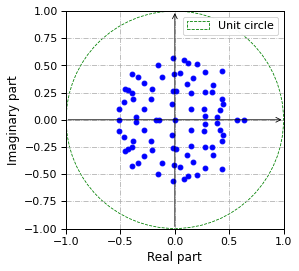

In [109]:
# create a discrete LDS object
print(state_deriv[:, :, 0][0].shape)
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)

print(lds)
lds.plot_eigs()

<DiscreteLinearSystem | 84 x 84, Condition 1656.1116016337862>


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

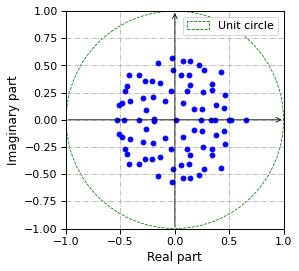

In [110]:
# compute it for noisy A
noisyA = lds.generate_noisy_A()
noisylds = DiscreteLinearSystem(A=noisyA)

print(noisylds)
noisylds.plot_eigs()

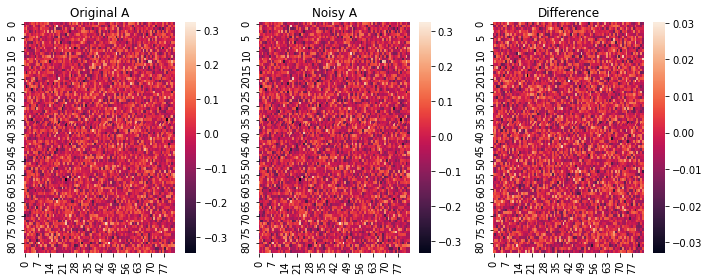

In [15]:
fig, axs = plt.subplots(1,3, figsize=(10, 4))

ax = sns.heatmap(lds.A, ax=axs[0])
ax.set_title('Original A')

ax = sns.heatmap(noisylds.A, ax=axs[1])
ax.set_title('Noisy A')

ax = sns.heatmap(lds.A - noisylds.A, ax=axs[2])
ax.set_title('Difference')
fig.tight_layout()

## Compute the Perturbation Norms of each Matrix (Gaussian and real Data generated)

## Real Data

In [16]:
radius = 1.5

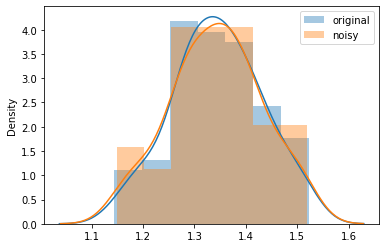

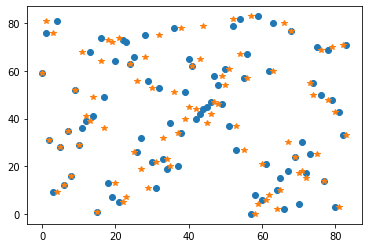

In [17]:
min_norm, min_freq, min_delta_vec = lds.compute_minimum_norm_perturbation(radius=radius)
orig_inds = np.argsort(min_norm)

noisymin_norm, min_freq, min_delta_vec = noisylds.compute_minimum_norm_perturbation(radius=radius)
noisy_inds = np.argsort(noisymin_norm)

fig, ax = plt.subplots()
sns.distplot(min_norm, ax=ax, label='original')
sns.distplot(noisymin_norm, ax=ax, label='noisy')
ax.legend()

fig, ax = plt.subplots()
ax.plot(orig_inds, 'o')
ax.plot(noisy_inds, '*')

In [24]:
# load in originally ran npy data
deriv_root = Path('/Users/adam2392/Dropbox/epilepsy_bids/derivatives/interictal/')
deriv_chain = Path('originalsampling') / 'fragility' / 'monopolar'

subject = 'pt1'
session = 'presurgery'
task = 'interictal'
acquisition = 'ecog'
datatype = 'ieeg'
desc = 'statematrix'
run = '01'

bids_path = BIDSPath(subject=subject, session=session, task=task,
                    acquisition=acquisition, datatype=datatype,
                    suffix=datatype, run=run)

deriv_basename = _add_desc_to_bids_fname(bids_path.copy().update(extension='.npy', check=False).basename, description=desc)
deriv_basename = Path(deriv_basename).with_suffix('.npy')
print(deriv_basename)

deriv_fpath = deriv_root / deriv_chain / f'sub-{subject}' / deriv_basename
state_deriv = read_derivative_npy(deriv_fpath, verbose=False)

sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-statematrix_ieeg.npy
LOADING AN OLD DATASET...


In [25]:
print(state_deriv)

<DerivativeNumpy | sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-statematrix_ieeg.npy, 84 x 3240 (404.9 s), ~168 kB, data not loaded>


In [26]:
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)
noisyA = lds.generate_noisy_A()
noisylds = DiscreteLinearSystem(A=noisyA)

print(lds.cond, noisylds.cond)

304.67297118475375 518.1066597508778


In [61]:
radius = 1.25

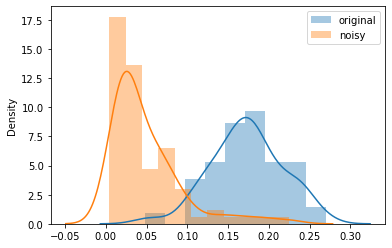

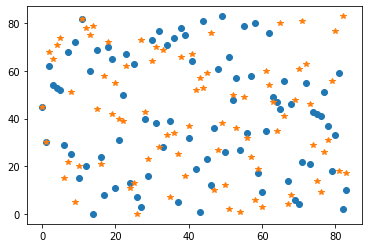

In [62]:
min_norm, min_freq, min_delta_vec = lds.compute_minimum_norm_perturbation(radius=radius)
orig_inds = np.argsort(min_norm)

noisymin_norm, min_freq, min_delta_vec = noisylds.compute_minimum_norm_perturbation(radius=radius)
noisy_inds = np.argsort(noisymin_norm)

fig, ax = plt.subplots()
sns.distplot(min_norm, ax=ax, label='original')
sns.distplot(noisymin_norm, ax=ax, label='noisy')
ax.legend()

fig, ax = plt.subplots()
ax.plot(orig_inds, 'o')
ax.plot(noisy_inds, '*')

In [64]:
vals = scipy.stats.energy_distance(noisymin_norm, min_norm)
print(vals)

vals = scipy.stats.wasserstein_distance(noisymin_norm, min_norm)
print(vals)


0.4056112376708425
0.12425095159492397


(1.164472117483779+0.09453295641613539j)


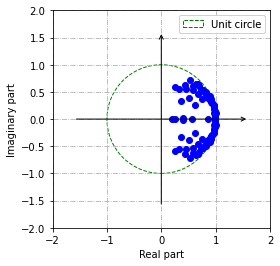

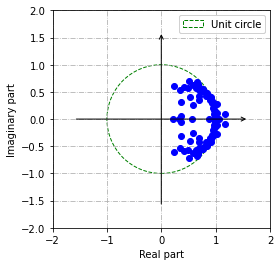

In [76]:
lds.plot_eigs()

noisylds.plot_eigs()
print(noisylds.eigs.max())

0.008061126552164496 0.22206765578719972


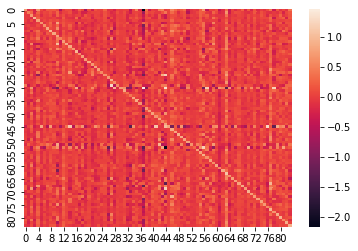

In [74]:
sns.heatmap(A)
print(np.mean(A), np.std(A))

In [111]:
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)
noisyA = lds.generate_noisy_A(mean = np.mean(A.flatten()), variance=0.2 / 100)
noisylds = DiscreteLinearSystem(A=noisyA)

print(lds.cond, noisylds.cond)

dists = {}
ranks = {}
for radius in np.linspace(1.1, 2.5, 100):
    min_norm, min_freq, min_delta_vec = lds.compute_minimum_norm_perturbation(radius=radius)
    orig_inds = np.argsort(min_norm)

    noisymin_norm, min_freq, min_delta_vec = noisylds.compute_minimum_norm_perturbation(radius=radius)
    noisy_inds = np.argsort(noisymin_norm)

    dist = scipy.stats.wasserstein_distance(noisymin_norm, min_norm)
    dists[radius] = dist
    
    noisy_inds = np.argsort(noisymin_norm)
    inds = np.argsort(min_norm)
    rank_dist = scipy.stats.kendalltau(inds, noisy_inds)
    ranks[radius] = rank_dist


9426.699437544328 1449.7128099006939


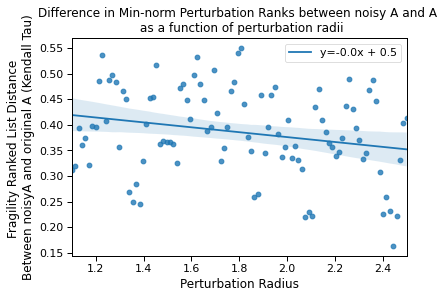

In [115]:
# measure kendall tau
fig, ax = plt.subplots()
x = ranks.keys()
y = ranks.values()
y = [res.correlation for res in y]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

sns.set_context('paper', font_scale=1.25, rc={'font.weight': 'bold'})
sns.regplot(x=list(x), y=list(y), ax=ax,
           line_kws={'label':"y={0:.1f}x + {1:.1f}".format(slope,intercept)})
ax.set(
    ylabel='Fragility Ranked List Distance \nBetween noisyA and original A (Kendall Tau)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation Ranks between noisy A and A \n as a function of perturbation radii'
)
# ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
# ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

No handles with labels found to put in legend.


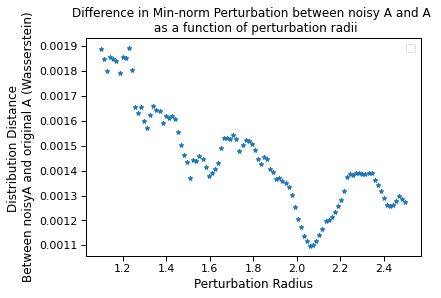

In [116]:
fig, ax = plt.subplots()
x = dists.keys()
y = dists.values()
ax.plot(x, y, '*')
ax.set(
    ylabel='Distribution Distance \nBetween noisyA and original A (Wasserstein)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation between noisy A and A \n as a function of perturbation radii'
)
# ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
# ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

## Simulated Gaussian Data

In [83]:
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)
noisyA = lds.generate_noisy_A(mean = np.mean(A.flatten()), variance=0.2 / 100)
noisylds = DiscreteLinearSystem(A=noisyA)

print(lds.cond, noisylds.cond)

dists = {}
ranks = {}
for radius in np.linspace(1.1, 2.5, 100):
    min_norm, min_freq, min_delta_vec = lds.compute_minimum_norm_perturbation(radius=radius)
    orig_inds = np.argsort(min_norm)

    noisymin_norm, min_freq, min_delta_vec = noisylds.compute_minimum_norm_perturbation(radius=radius)
    noisy_inds = np.argsort(noisymin_norm)

    dist = scipy.stats.wasserstein_distance(noisymin_norm, min_norm)
    dists[radius] = dist
    
    noisy_inds = np.argsort(noisymin_norm)
    inds = np.argsort(min_norm)
    rank_dist = scipy.stats.kendalltau(inds, noisy_inds)
    ranks[radius] = rank_dist


304.67297118475375 214.30077088591253


In [91]:
print(len(x), len(y))
print(rank_dist)

100 100
KendalltauResult(correlation=0.18187033849684453, pvalue=0.014317500217809384)


/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


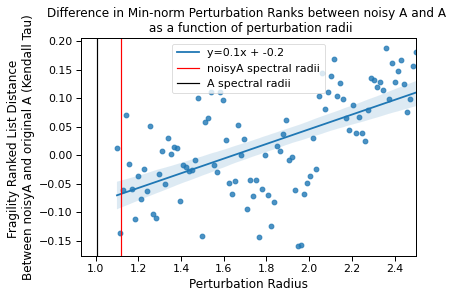

In [106]:
# measure kendall tau
fig, ax = plt.subplots()
x = ranks.keys()
y = ranks.values()
y = [res.correlation for res in y]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

sns.set_context('paper', font_scale=1.25, rc={'font.weight': 'bold'})
sns.regplot(x=list(x), y=list(y), ax=ax,
           line_kws={'label':"y={0:.1f}x + {1:.1f}".format(slope,intercept)})
ax.set(
    ylabel='Fragility Ranked List Distance \nBetween noisyA and original A (Kendall Tau)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation Ranks between noisy A and A \n as a function of perturbation radii'
)
ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

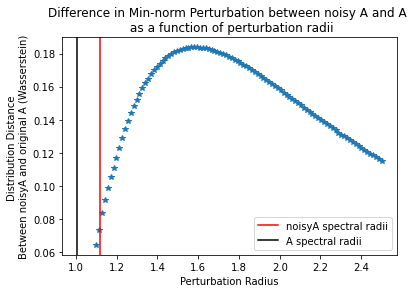

In [85]:
fig, ax = plt.subplots()
x = dists.keys()
y = dists.values()
ax.plot(x, y, '*')
ax.set(
    ylabel='Distribution Distance \nBetween noisyA and original A (Wasserstein)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation between noisy A and A \n as a function of perturbation radii'
)
ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

# Min-norm distribution differences as a function of additive perturbation on the data

Here we load in real data and apply perturbations ON the rawdata itself before fragility is computed. This is different from essentially multiplicative perturbations added onto the A matrix. This is the analysis of noise present in the data that leans us away from the true system.

In [9]:
# load in data
root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
deriv_chain = Path('originalsampling') / 'radius1.5' / 'fragility' / reference

In [16]:
subject = 'pt1'
session = 'presurgery'
acquisition = 'ecog'
run = '01'
datatype = 'ieeg'
extension = '.vhdr'

In [14]:
subjects = get_entity_vals(root, 'subject')
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subjects)
ignore_sessions = [ses for ses in sessions if ses != session]

tasks = get_entity_vals(root, 'task', 
                        ignore_subjects=ignore_subjects,
                        ignore_sessions=ignore_sessions
                       )

task = tasks[0]

print(task)

ictal


In [17]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr


## Load raw data

In [21]:
raw = read_raw_bids(bids_path, verbose=False)

print(raw)

<RawBrainVision | sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 98 x 269080 (269.1 s), ~103 kB, data not loaded>


<ipython-input-21-93eddeff2657>:1: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-21-93eddeff2657>:1: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  raw = read_raw_bids(bids_path, verbose=False)


In [22]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<RawBrainVision | sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 84 x 269080 (269.1 s), ~172.5 MB, data loaded>
Band pass filtering between 0.5 and 300
Notch filtering at [ 60 120 180 240]


## Run Additive Noise Experiment

In [27]:
rawdata = raw.get_data(start=100, stop=600)

print(rawdata.shape)

(84, 500)


In [132]:
# simulate Gaussian noise process
mean = 0
mean_vec = [mean] * n_chs
variance = 1
# generate random SPD matrix with norm 1
cov = make_spd_matrix(n_chs, random_state=random_state)
cov = cov / np.linalg.norm(cov)

n_chs = len(raw.ch_names) 
noise = []
for idx in range(n_chs):
    # generate colored noise
    ch_data = pink_noise(n_points=rawdata.shape[1]) * 1e-5
    
    # generate white noise
#     ch_data = np.random.normal(mean + np.random.random() * 0.0001, (variance + np.random.random()) * 1e-5, rawdata.shape[1])
#     print(ch_data.mean(), ch_data.std())
    noise.append(ch_data)
    
noise = np.array(noise)
noisy_data = np.add(rawdata, noise)
print(noisy_data.shape)

(84, 500)


In [133]:
mvarmodel = MvarModel()
noisyA = mvarmodel.fit(noisy_data)
A = mvarmodel.fit(rawdata)

In [134]:
lds = DiscreteLinearSystem(A=A)

noisylds = DiscreteLinearSystem(A=noisyA)

print(lds.cond, noisylds.cond)

68.87073913824582 35.32937250620105


In [135]:
print(f'The norm of the noise was: {np.linalg.norm(noise)}')
print('Noise statistics: ', noise.mean(), noise.std())
print('Raw data statistics: ', rawdata.mean(), rawdata.std())

The norm of the noise was: 0.0020982416811072273
Noise statistics:  4.4870277600283777e-07 1.0228533987873605e-05
Raw data statistics:  -0.00018399786646643873 0.00018697640379925073


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

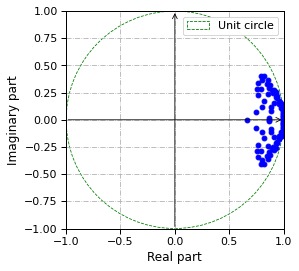

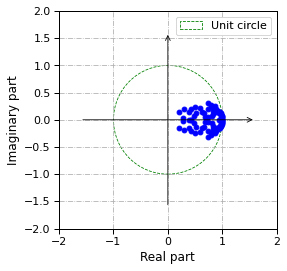

In [136]:
lds.plot_eigs()

noisylds.plot_eigs()

In [137]:
dists = {}
ranks = {}
for radius in np.linspace(1.1, 2.5, 10):
    min_norm, min_freq, min_delta_vec = lds.compute_minimum_norm_perturbation(radius=radius)
    orig_inds = np.argsort(min_norm)

    noisymin_norm, min_freq, min_delta_vec = noisylds.compute_minimum_norm_perturbation(radius=radius)
    noisy_inds = np.argsort(noisymin_norm)

    dist = scipy.stats.wasserstein_distance(noisymin_norm, min_norm)
    dists[radius] = dist
    
    noisy_inds = np.argsort(noisymin_norm)
    inds = np.argsort(min_norm)
    rank_dist = scipy.stats.kendalltau(inds, noisy_inds)
    ranks[radius] = rank_dist


### Additive Color Noise

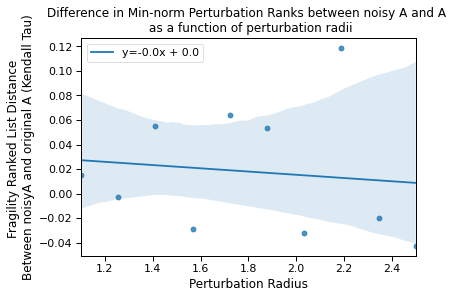

In [138]:
# measure kendall tau
fig, ax = plt.subplots()
x = ranks.keys()
y = ranks.values()
y = [res.correlation for res in y]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

sns.set_context('paper', font_scale=1.25, rc={'font.weight': 'bold'})
sns.regplot(x=list(x), y=list(y), ax=ax,
           line_kws={'label':"y={0:.1f}x + {1:.1f}".format(slope,intercept)})
ax.set(
    ylabel='Fragility Ranked List Distance \nBetween noisyA and original A (Kendall Tau)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation Ranks between noisy A and A \n as a function of perturbation radii'
)
# ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
# ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


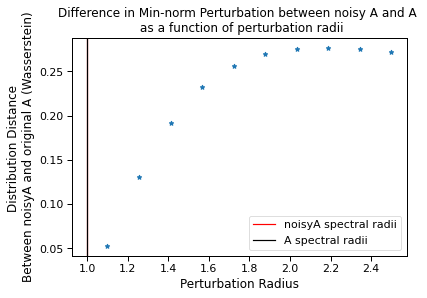

In [139]:
fig, ax = plt.subplots()
x = dists.keys()
y = dists.values()
ax.plot(x, y, '*')
ax.set(
    ylabel='Distribution Distance \nBetween noisyA and original A (Wasserstein)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation between noisy A and A \n as a function of perturbation radii'
)
ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

### Additive White Noise

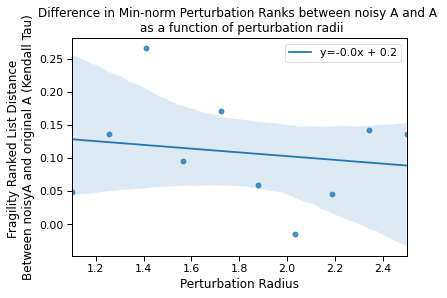

In [84]:
# measure kendall tau
fig, ax = plt.subplots()
x = ranks.keys()
y = ranks.values()
y = [res.correlation for res in y]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

sns.set_context('paper', font_scale=1.25, rc={'font.weight': 'bold'})
sns.regplot(x=list(x), y=list(y), ax=ax,
           line_kws={'label':"y={0:.1f}x + {1:.1f}".format(slope,intercept)})
ax.set(
    ylabel='Fragility Ranked List Distance \nBetween noisyA and original A (Kendall Tau)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation Ranks between noisy A and A \n as a function of perturbation radii'
)
# ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
# ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()

/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


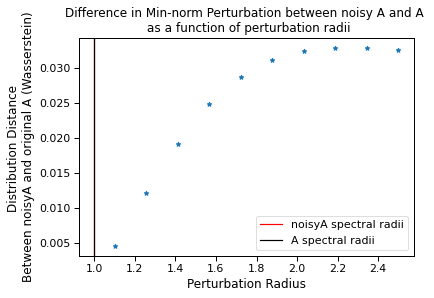

In [85]:
fig, ax = plt.subplots()
x = dists.keys()
y = dists.values()
ax.plot(x, y, '*')
ax.set(
    ylabel='Distribution Distance \nBetween noisyA and original A (Wasserstein)',
    xlabel='Perturbation Radius',
    title='Difference in Min-norm Perturbation between noisy A and A \n as a function of perturbation radii'
)
ax.axvline(noisylds.eigs.max(), label='noisyA spectral radii', color='red')
ax.axvline(lds.eigs.max(), label='A spectral radii', color='black')
ax.legend()